In [1]:
#From the tutorial https://www.intodeeplearning.com/bert-multiclass-text-classification/

!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 17.4 MB/s eta 0:00:00


In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cd drive/MyDrive

In [5]:
!git clone https://github.com/BestBuyAPIs/open-data-set

Cloning into 'open-data-set'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13
Unpacking objects: 100% (13/13), 13.62 MiB | 7.88 MiB/s, done.


In [6]:
cd open-data-set

/content/open-data-set


In [7]:
import json
f = open('products.json')
data = json.load(f) # returns JSON object as a dictionary

In [8]:
import pandas as pd
# creating dataframe with three rows (name,description,categories)
column_names = ['name','description','categories']
df = pd.DataFrame(columns = column_names)

names,descriptions,categories = [],[],[]
for product in data:
  names.append(product['name'])
  descriptions.append(product['description'])
  productCategories = []
  for cat in product['category']:
    productCategories.append(cat['name'])
  categories.append(productCategories)
  
df = pd.DataFrame(list(zip(names,descriptions,categories)) ,columns = column_names)

In [9]:
df['categories']=[df['categories'][i][0] for i in range(0,len(df['categories']))]

In [10]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [11]:
#Taking only product categories with > 100 elements
df=df.groupby('categories').filter(lambda x : len(x)>100)


In [12]:
possible_labels = df.categories.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Connected Home & Housewares': 0,
 'Car Electronics & GPS': 1,
 'Musical Instruments': 2,
 'Toys, Games & Drones': 3,
 'Video Games': 4,
 'Cameras & Camcorders': 5,
 'Computers & Tablets': 6,
 'Appliances': 7,
 'Audio': 8,
 'TV & Home Theater': 9,
 'Health, Fitness & Beauty': 10,
 'Name Brands': 11,
 'Cell Phones': 12,
 'Magnolia Home Theater': 13,
 'Best Buy Gift Cards': 14,
 'Wearable Technology': 15}

In [13]:
df['label'] = df.categories.replace(label_dict)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(list(df.name.values), 
                                                  list(df.label.values), 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values
                                                  )

In [15]:
df['categories'].value_counts()

Appliances                     9317
Cell Phones                    6905
Computers & Tablets            6088
Video Games                    5837
Connected Home & Housewares    4968
Cameras & Camcorders           3645
Audio                          3603
Musical Instruments            3013
Car Electronics & GPS          2673
TV & Home Theater              2215
Health, Fitness & Beauty       1265
Toys, Games & Drones            669
Best Buy Gift Cards             454
Wearable Technology             283
Name Brands                     214
Magnolia Home Theater           148
Name: categories, dtype: int64

In [16]:
from transformers import BertTokenizer
PRETRAINED_LM = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)

In [17]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [18]:
train_input_ids, train_att_masks = encode([str(i) for i in X_train])
valid_input_ids, valid_att_masks = encode([str(i) for i in X_test])

In [19]:
import torch
train_y = torch.LongTensor(y_train)
valid_y = torch.LongTensor(y_test)

In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [21]:
from transformers import BertForSequenceClassification
N_labels = len(possible_labels)
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
model = model.cuda()

In [24]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 5
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

In [25]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        
        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))              


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()
   
            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
        
    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(X_train) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(X_test) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/2726 [00:00<?, ?it/s]

Validation:   0%|          | 0/481 [00:00<?, ?it/s]

2726/2726 train loss: 1.193772401297171 
481/481 val loss: 0.5295573865487521 
Epoch:  2


Training:   0%|          | 0/2726 [00:00<?, ?it/s]

Validation:   0%|          | 0/481 [00:00<?, ?it/s]

2726/2726 train loss: 0.4656012787491149 
481/481 val loss: 0.35462987210345986 
Epoch:  3


Training:   0%|          | 0/2726 [00:00<?, ?it/s]

Validation:   0%|          | 0/481 [00:00<?, ?it/s]

2726/2726 train loss: 0.34727736792553787 
481/481 val loss: 0.30547238980843966 
Epoch:  4


Training:   0%|          | 0/2726 [00:00<?, ?it/s]

Validation:   0%|          | 0/481 [00:00<?, ?it/s]

2726/2726 train loss: 0.2977020907723458 
481/481 val loss: 0.28591653088150304 
Epoch:  5


Training:   0%|          | 0/2726 [00:00<?, ?it/s]

Validation:   0%|          | 0/481 [00:00<?, ?it/s]

2726/2726 train loss: 0.2744597364401531 
481/481 val loss: 0.2784959654848473 


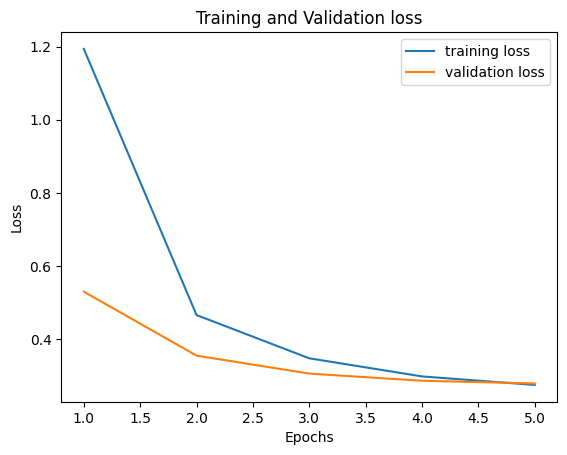

In [26]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [27]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(valid_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()
   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [31]:
from sklearn.metrics import classification_report

print('classifiation report')
print(classification_report(test_pred, np.array(y_test),target_names=possible_labels))

classifiation report
                             precision    recall  f1-score   support

Connected Home & Housewares       0.93      0.92      0.92       756
      Car Electronics & GPS       0.89      0.92      0.90       389
        Musical Instruments       0.90      0.92      0.91       440
       Toys, Games & Drones       0.60      0.86      0.71        70
                Video Games       0.98      0.99      0.98       871
       Cameras & Camcorders       0.93      0.92      0.92       558
        Computers & Tablets       0.94      0.93      0.94       929
                 Appliances       0.99      0.98      0.98      1413
                      Audio       0.95      0.89      0.92       578
          TV & Home Theater       0.89      0.87      0.88       339
   Health, Fitness & Beauty       0.88      0.86      0.87       195
                Name Brands       0.00      0.00      0.00         0
                Cell Phones       0.96      0.95      0.96      1051
      Magnol

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
